In [1]:
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import pytz
import datetime as dt
import numpy as np

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
rate = 30
interval = '15m'
limit = 1000

In [4]:
data = json.dumps({'method':'SUBSCRIBE','params':[symbol + '@kline_' + interval],'id':1})
df = pd.DataFrame()

In [5]:
def get_historical(symbol, interval, limit):
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol_C,
              "interval": interval,
              "limit": limit}
    response = requests.get(url, params=params).json()
    df = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                           "Volume", "Close_Time", "Quote asset volume",
                                           "Number of trades", "Taker buy base asset volume",
                                           "Taker buy quote asset volume", "Ignore"])
    df = df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    df = df.astype(convert_dict)
    return df

In [6]:
df = get_historical(symbol, interval, limit)
df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit = 'ms')
df['Close_Time'] = df['Close_Time'] + pd.Timedelta(hours=timezone)
df['Closed'] = True
print(df)

                       Close_Time     Open    Close     High      Low  \
0   2023-02-04 10:44:59.999000064  1652.36  1654.30  1655.46  1652.27   
1   2023-02-04 10:59:59.999000064  1654.31  1657.69  1659.24  1654.09   
2   2023-02-04 11:14:59.999000064  1657.69  1656.24  1658.21  1654.94   
3   2023-02-04 11:29:59.999000064  1656.24  1655.53  1658.35  1655.49   
4   2023-02-04 11:44:59.999000064  1655.53  1654.03  1655.65  1651.77   
..                            ...      ...      ...      ...      ...   
995 2023-02-14 19:29:59.999000064  1505.40  1508.89  1509.37  1505.00   
996 2023-02-14 19:44:59.999000064  1508.89  1506.34  1509.21  1505.64   
997 2023-02-14 19:59:59.999000064  1506.34  1507.70  1507.70  1505.71   
998 2023-02-14 20:14:59.999000064  1507.70  1507.45  1509.80  1507.17   
999 2023-02-14 20:29:59.999000064  1507.46  1511.55  1511.55  1507.26   

        Volume  Closed  
0    1977.0469    True  
1    1814.8556    True  
2    1281.6376    True  
3    1104.7523    True 

In [7]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,Closed,sma,bb_u,bb_m,bb_l,rsi
0,2023-02-04 10:44:59.999000064,1652.36,1654.30,1655.46,1652.27,1977.0469,True,NaN,NaN,NaN,NaN,NaN
1,2023-02-04 10:59:59.999000064,1654.31,1657.69,1659.24,1654.09,1814.8556,True,NaN,NaN,NaN,NaN,NaN
2,2023-02-04 11:14:59.999000064,1657.69,1656.24,1658.21,1654.94,1281.6376,True,NaN,NaN,NaN,NaN,NaN
3,2023-02-04 11:29:59.999000064,1656.24,1655.53,1658.35,1655.49,1104.7523,True,NaN,NaN,NaN,NaN,NaN
4,2023-02-04 11:44:59.999000064,1655.53,1654.03,1655.65,1651.77,1163.4729,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023-02-14 19:29:59.999000064,1505.40,1508.89,1509.37,1505.00,2576.7592,True,1503.677000,1512.086879,1503.677000,1495.267121,58.002783
996,2023-02-14 19:44:59.999000064,1508.89,1506.34,1509.21,1505.64,1714.3995,True,1503.968000,1512.118158,1503.968000,1495.817842,53.013840
997,2023-02-14 19:59:59.999000064,1506.34,1507.70,1507.70,1505.71,1769.9763,True,1504.163000,1512.380779,1504.163000,1495.945221,55.225769
998,2023-02-14 20:14:59.999000064,1507.70,1507.45,1509.80,1507.17,2311.9466,True,1504.402000,1512.571066,1504.402000,1496.232934,54.715851


In [9]:
def conditions(df):
    # 進場條件
    # 下影線 大於 實體Ｋ
    # 收盤 小於 布林下
    # 紅Ｋ (discarded)

    for index, row in df.iterrows():
        # red candle
        df['c1_1'] = abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])
        # green candle
        df['c1_2'] = abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])
        df['c2'] = df['Close'] < df['bb_l']
#         df['c3'] = df['Close'] < df['Open']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1_1 & df.c1_2 & df.c2 , 'signal'] = True

    df = df.reset_index(drop=True)

    # 下根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,Closed,sma,bb_u,bb_m,bb_l,rsi,c1_1,c1_2,c2,signal,openbuy
0,2023-02-04 10:44:59.999000064,1652.36,1654.30,1655.46,1652.27,1977.0469,True,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False
1,2023-02-04 10:59:59.999000064,1654.31,1657.69,1659.24,1654.09,1814.8556,True,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False
2,2023-02-04 11:14:59.999000064,1657.69,1656.24,1658.21,1654.94,1281.6376,True,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False
3,2023-02-04 11:29:59.999000064,1656.24,1655.53,1658.35,1655.49,1104.7523,True,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False
4,2023-02-04 11:44:59.999000064,1655.53,1654.03,1655.65,1651.77,1163.4729,True,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023-02-14 19:29:59.999000064,1505.40,1508.89,1509.37,1505.00,2576.7592,True,1503.677000,1512.086879,1503.677000,1495.267121,58.002783,True,False,False,False,False
996,2023-02-14 19:44:59.999000064,1508.89,1506.34,1509.21,1505.64,1714.3995,True,1503.968000,1512.118158,1503.968000,1495.817842,53.013840,False,True,False,False,False
997,2023-02-14 19:59:59.999000064,1506.34,1507.70,1507.70,1505.71,1769.9763,True,1504.163000,1512.380779,1504.163000,1495.945221,55.225769,True,False,False,False,False
998,2023-02-14 20:14:59.999000064,1507.70,1507.45,1509.80,1507.17,2311.9466,True,1504.402000,1512.571066,1504.402000,1496.232934,54.715851,True,True,False,False,False


In [11]:
buydf = conditions(df)

# 進出場
in_position = False
stop_loss = np.nan
for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根k線收盤價進場)
        # set stop loss (前一根k線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)
# df.to_csv('buydf.csv')


                       Close_Time     Open    Close     High      Low  \
89  2023-02-05 08:59:59.999000064  1669.15  1663.47  1669.50  1657.49   
90  2023-02-05 09:14:59.999000064  1663.47  1665.40  1665.59  1660.55   
120 2023-02-05 16:44:59.999000064  1667.79  1671.57  1673.81  1666.87   
137 2023-02-05 20:59:59.999000064  1658.88  1648.20  1660.70  1635.93   
138 2023-02-05 21:14:59.999000064  1648.19  1641.80  1648.63  1640.69   
..                            ...      ...      ...      ...      ...   
893 2023-02-13 17:59:59.999000064  1484.21  1482.36  1492.51  1481.72   
894 2023-02-13 18:14:59.999000064  1482.36  1481.50  1487.97  1479.69   
895 2023-02-13 18:29:59.999000064  1481.50  1474.80  1482.76  1466.00   
896 2023-02-13 18:44:59.999000064  1474.80  1480.80  1480.90  1474.36   
929 2023-02-14 02:59:59.999000064  1484.71  1488.96  1493.91  1484.56   

         Volume  Closed          sma         bb_u         bb_m         bb_l  \
89    6007.9127    True  1676.345667  1687.1

In [22]:
# 部位回測
posdf = buydf
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]


pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == index - 1:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)

    
        

# pos.to_csv('pos.csv')

# 損益
leverage = 10
ttl_profit = -pos.amt.sum()


pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()

group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())

max_entry = group_consec.max()

print(max_entry)
print(pos)

ttl_entry = 0
for i in range(len(pos) - 1):
    if pos.loc[i, 'position'] == 'Buy':
        ttl_entry += pos.loc[i, 'entry_p'] * pos.loc[i, 'size']

profit_per = "{:.2f}%".format(ttl_profit / (ttl_entry/leverage))
        
print(ttl_profit, profit_per)



4869.42
                      Close_Time     Open    Close     High      Low  \
0  2023-02-05 09:14:59.999000064  1663.47  1665.40  1665.59  1660.55   
1  2023-02-05 16:44:59.999000064  1667.79  1671.57  1673.81  1666.87   
2  2023-02-05 21:14:59.999000064  1648.19  1641.80  1648.63  1640.69   
3  2023-02-06 01:14:59.999000064  1639.08  1635.43  1641.29  1631.09   
4  2023-02-06 02:29:59.999000064  1622.62  1619.73  1624.52  1619.19   
5  2023-02-06 08:44:59.999000064  1639.18  1641.37  1642.53  1635.71   
6  2023-02-06 13:59:59.999000064  1617.25  1621.55  1621.56  1616.37   
7  2023-02-06 23:59:59.999000064  1626.80  1649.01  1649.30  1626.40   
8  2023-02-07 07:44:59.999000064  1611.77  1615.64  1615.99  1606.66   
9  2023-02-07 07:59:59.999000064  1615.64  1614.29  1617.80  1613.70   
10 2023-02-07 17:14:59.999000064  1630.41  1641.01  1643.16  1630.40   
11 2023-02-09 00:44:59.999000064  1639.22  1644.25  1645.12  1632.20   
12 2023-02-09 00:59:59.999000064  1644.26  1653.47  1653

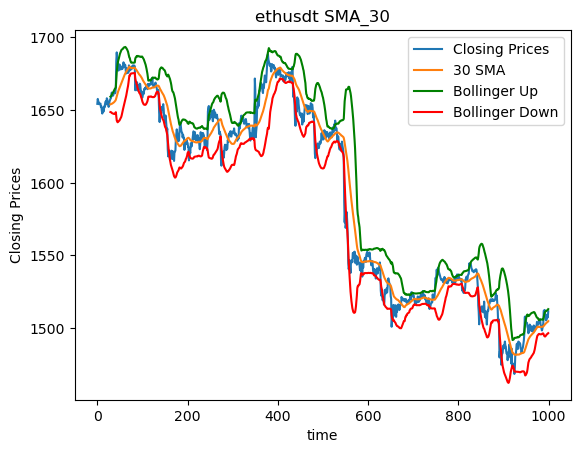

In [13]:
plt.title(symbol + ' SMA_' + str(rate))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(rate) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()